implementing Convolutional Neural Net to learn handwritten digits, weights and biases written explicitely without using any prebuild layers from torch

In [2]:
from datasets import load_dataset #type: ignore
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np

/opt/anaconda3/envs/env1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds = load_dataset("ylecun/mnist")   #the mnist dataset

In [4]:
train_dataset = ds['train']
test_dataset = ds['test']

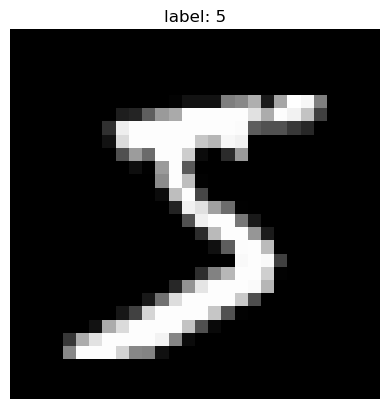

In [5]:
example = ds['train'][0]
image = example['image']
plt.imshow(image, cmap='gray')
plt.title(f"label: {example['label']}")
plt.axis('off')
plt.show()

In [6]:
image_tensor = torch.tensor(np.array(image), dtype=torch.float32)

In [7]:
image_tensor.shape

torch.Size([28, 28])

In [8]:
#going to implement CNN for this

In [9]:
X_tr = torch.tensor([np.array(img, dtype=np.float32)/255 for img in ds['train']['image']])
X_tr.shape

/var/folders/t6/s1wr8gp14gl28npcdk0thstc0000gn/T/ipykernel_1324/1360348788.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  X_tr = torch.tensor([np.array(img, dtype=np.float32)/255 for img in ds['train']['image']])


torch.Size([60000, 28, 28])

In [67]:
X_te = torch.tensor([np.array(img, dtype=np.float32)/255 for img in ds['test']['image']])
X_te.shape

torch.Size([10000, 28, 28])

In [18]:
Y_tr = torch.tensor(ds['train']['label'], dtype=torch.int32)
Y_tr.shape

torch.Size([60000])

In [68]:
Y_te = torch.tensor(ds['test']['label'], dtype=torch.int32)
Y_te.shape

torch.Size([10000])

In [19]:
Y_tr

tensor([5, 0, 4,  ..., 5, 6, 8], dtype=torch.int32)

In [20]:
#converting X_tr to (60000, 196, 4) dim tensor
X_tr_unfolded = X_tr.unfold(2, 2, 2).unfold(3, 2, 2).contiguous().view(60000, -1, 4)

In [21]:
X_tr_unfolded.shape

torch.Size([60000, 196, 4])

In [30]:
W1 = torch.randn((196, 4))
b1 = torch.randn((196, ))

l1 = (W1*X_tr_unfolded).sum(dim=2) + b1 #element wise mult done by * and summation along dim 2, 14*14

W2 = torch.randn((196, 196))
b2 = torch.randn((196, ))

l2 = (l1@W2) + b2  #14*14
#changing the view of l2 
l2 = l2.view(60000, 14, 14)
l2_unfolded = l2.unfold(2, 2, 2).unfold(3, 2, 2).contiguous().view(60000, -1, 4)

W3 = torch.randn((49, 4))
b3 = torch.randn((49, ))

l3 = (W3*l2_unfolded).sum(dim=2) + b3  #7*7

W4 = torch.randn((49, 49))
b4 = torch.randn((49, ))

l4 = (l3@W4) + b4  # 7*7

W5 = torch.randn((49, 10))
b5 = torch.randn((10, ))

logits = (l4@W5) + b5

#loss
nll = F.cross_entropy(logits, Y_tr.long())

In [34]:
nll  #loss of 1816 at the start, lets see how this can be reduced

tensor(1816.4763)

In [31]:
Y_tr

tensor([5, 0, 4,  ..., 5, 6, 8], dtype=torch.int32)

In [32]:
Y_tr.shape

torch.Size([60000])

In [33]:
logits.shape

torch.Size([60000, 10])

In [123]:
l1.shape

torch.Size([60000, 196])

In [35]:
#doing it fresh from here

In [48]:
g = torch.Generator().manual_seed(2147483647)

In [63]:
W1 = torch.randn((196, 4), generator=g, requires_grad=True)
b1 = torch.randn((196, ), generator=g, requires_grad=True)

W2 = torch.randn((196, 196), generator=g, requires_grad=True)
b2 = torch.randn((196, ), generator=g, requires_grad=True)

W3 = torch.randn((49, 4), generator=g, requires_grad=True)
b3 = torch.randn((49, ), generator=g, requires_grad=True)

W4 = torch.randn((49, 49), generator=g, requires_grad=True)
b4 = torch.randn((49, ), generator=g, requires_grad=True)

W5 = torch.randn((49, 10), generator=g, requires_grad=True)
b5 = torch.randn((10, ), generator=g, requires_grad=True)

parameters = [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5]

In [64]:
sum(p.nelement() for p in parameters)  #num of params 

42787

In [ ]:
#gradient descent 
for _ in range(3000):
    #forward pass
    l1 = (W1*X_tr_unfolded).sum(dim=2) + b1
    
    l2 = (l1@W2) + b2  
    l2 = l2.view(60000, 14, 14)
    l2_unfolded = l2.unfold(2, 2, 2).unfold(3, 2, 2).contiguous().view(60000, -1, 4)

    l3 = (W3*l2_unfolded).sum(dim=2) + b3

    l4 = (l3@W4) + b4

    logits = (l4@W5) + b5

    nll = F.cross_entropy(logits, Y_tr.long())
    print(f"loss at epoch {_+1}: {nll.item()}")


    #backprop
    for p in parameters:
        p.grad = None

    nll.backward()


    #update params
    alpha = 0.001
    for p in parameters:
        # if (p.grad < 0):  #to stop training if we overshot local minima
        #     break
        # else:
        p.data += -alpha*p.grad

In [66]:
#egs code below
nll

tensor(4.3497, grad_fn=<NllLossBackward0>)

In [70]:
#test loss

X_te_unfolded = X_te.unfold(2, 2, 2).unfold(3, 2, 2).contiguous().view(10000, -1, 4)

l1 = (W1*X_te_unfolded).sum(dim=2) + b1

l2 = (l1@W2) + b2  
l2 = l2.view(10000, 14, 14)
l2_unfolded = l2.unfold(2, 2, 2).unfold(3, 2, 2).contiguous().view(10000, -1, 4)

l3 = (W3*l2_unfolded).sum(dim=2) + b3

l4 = (l3@W4) + b4

logits = (l4@W5) + b5

nll = F.cross_entropy(logits, Y_te.long())
print(f"loss at test: {nll.item()}")

loss at test: 4.447265148162842


In [71]:
def out_logits(X):
    X_unfolded = X.unfold(2, 2, 2).unfold(3, 2, 2).contiguous().view(X.shape[0], -1, 4)

    l1 = (W1*X_unfolded).sum(dim=2) + b1

    l2 = (l1@W2) + b2  
    l2 = l2.view(X.shape[0], 14, 14)
    l2_unfolded = l2.unfold(2, 2, 2).unfold(3, 2, 2).contiguous().view(X.shape[0], -1, 4)

    l3 = (W3*l2_unfolded).sum(dim=2) + b3

    l4 = (l3@W4) + b4

    logits = (l4@W5) + b5

    return logits

In [92]:
#getting some predictions
logits_1 = out_logits(X_te)
probs = F.softmax(logits_1, dim=1)
# print(probs)

max_probs, max_indices = torch.max(probs, dim=1)
print(max_indices)
print(Y_te)   #almost all match
#loss went down from 1700 to 4, pretty good amount

tensor([7, 2, 1,  ..., 4, 5, 6])
tensor([7, 2, 1,  ..., 4, 5, 6], dtype=torch.int32)


In [ ]:
#some rough work

In [113]:
X = torch.tensor([
    [[
        [1, 2, 3, 4],
        [11, 12, 13, 14],
        [21, 22, 23, 24],
        [31, 32, 33, 34]
    ], 
    [
        [100, 200, 300, 400],
        [110, 120, 130, 140],
        [210, 220, 230, 240],
        [310, 320, 330, 340]
    ]
    ]
], dtype=torch.float32)


In [114]:
X_un = X.unfold(2, 2, 2).unfold(3, 2, 2).contiguous().view(2, -1, 4)

In [117]:
W = torch.randn((4, 4))
l = (W*X_un).sum(dim=2)

In [118]:
X_un

tensor([[[  1.,   2.,  11.,  12.],
         [  3.,   4.,  13.,  14.],
         [ 21.,  22.,  31.,  32.],
         [ 23.,  24.,  33.,  34.]],

        [[100., 200., 110., 120.],
         [300., 400., 130., 140.],
         [210., 220., 310., 320.],
         [230., 240., 330., 340.]]])

In [119]:
l

tensor([[  24.7785,    1.9992,  -18.1983,  -24.0900],
        [ 737.3009, -781.8102, -181.9827, -240.8997]])